# Visualize pymoo result
Load the pymoo result object saved with pickle and visualize it.

ONOSControllerPlacement needs to be definded to load the result object.
So, execute the following cell first.

In [10]:
#!/usr/bin/env python
import numpy as np
import networkx as nx
import math
import pickle
from pymoo.core.problem import ElementwiseProblem

class ONOSControllerPlacement(ElementwiseProblem):
    def __init__(self, num_nodes, distance_matrix, shortest_paths, graph, **kwargs):
        super().__init__(n_var=2*num_nodes, 
                         n_obj=4, 
                         n_constr=2, 
                         xl=0, xu=1, 
                         **kwargs)
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.shortest_paths = shortest_paths
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        controller_nodes = x[:self.num_nodes]   # first half is controller placement
        atomix_nodes = x[self.num_nodes:]       # second half is atomix placement


        num_controller = np.sum(controller_nodes)
        num_atomix = np.sum(atomix_nodes)

        # Obj1: Minimize number of contrtoller
        f1 = num_controller

        # Obj2: Minimize number of atomix
        f2 = num_atomix

        # Obj3: Minimize average FSP
        f3 = calculate_FST(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                           self.shortest_paths)
        
        f4 = calculate_BC(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                        #    self.shortest_paths,
                           self.graph)

        # Constr1: The number of controller is equal to or greater than 2
        g1 = 2 - num_controller

        # Constr2: The number of atomix is equal to or greater than 3
        g2 = 3 - num_atomix
        
        # Add the centrality metrix into optimazing objectives:
        # 1. Nearest controller for each switch
        # 2. The number of controlled switches for each controller should be <= limit_num_switches_controlled (limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)))
        # 3. return value should be the variance for all controller's betweenness centrality
        out["F"] = [f1, f2, f3, f4]
        out["G"] = [g1, g2]


def calculate_FST(num_nodes, controller_nodes, atomix_nodes, distance_matrix, shortest_paths):
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()
    atomix_list = np.nonzero(atomix_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        for c in controller_list:
            if distance_matrix[s][c] < delay:
                delay = distance_matrix[s][c]
                nearest_controller = c
        controller_of.append(nearest_controller)    

    # calculate average delay to atomix nodes from each controller
    average_atomix_delay_from = {}
    for c in controller_list:
        delay = []
        for a in atomix_list:
            delay.append(distance_matrix[c][a])
        average_atomix_delay_from[c] = np.mean(delay)

    # find the nearest atomix for each atomix and calculate average delay
    atomix_atomix_delays = []
    for a1 in atomix_list:
        delay = math.inf
        for a2 in atomix_list:
            if(a1 == a2):
                continue
            if distance_matrix[a1][a2] < delay:
                delay = distance_matrix[a1][a2]
        atomix_atomix_delays.append(delay)
    average_atomix_atomix_delay = np.mean(atomix_atomix_delays)
    FTSs = []
    for source in range(num_nodes):
        for distination in range(num_nodes):
            if(source == distination):
                continue
            delay = 0
            is_controlled_by_single_controller = True
            counted_controllers = []
            for s in shortest_paths[source][distination]:
                # switch-controller delay
                delay += distance_matrix[s][controller_of[s]] * 4

                # controller-atomix delay
                if(s == source):
                    delay += average_atomix_delay_from[controller_of[s]] * 2
                elif(s != distination):
                    if(controller_of[s] != controller_of[source]):
                        is_controlled_by_single_controller = False
                        if(not controller_of[s] in counted_controllers):
                            counted_controllers.append(controller_of[s])
                            delay += average_atomix_delay_from[controller_of[s]]
                else:
                    if(controller_of[s] == controller_of[source]):
                        if(not is_controlled_by_single_controller):
                            delay += average_atomix_delay_from[controller_of[s]]
                    else:
                        delay += average_atomix_delay_from[controller_of[s]] * 2
            
            # atomix-atomix delay
            delay +=  average_atomix_atomix_delay * 2
            FTSs.append(delay)

    return np.mean(FTSs)



def calculate_BC(num_nodes, controller_nodes, atomix_nodes, distance_matrix, graph):
    G = nx.Graph()
    for node1 in range(len(graph)):
        G.add_node(str(node1))
        for node2, delay in graph[node1].items():
            G.add_edge(str(node1), str(node2), weight=delay)
    
    # The list of betweenness centrality for all switches
    nodes_bc=nx.current_flow_betweenness_centrality(G, normalized=True, weight=None, dtype='float', solver='full')
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)) # balance the number of switches controllers can control 
    switches_bc_of_controller_ = dict.fromkeys((range(num_nodes)),0) # list of sum of betweenness centrality of switches for each controller
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        controlled_switches=[]
        for c in controller_list:
            # Conditions: nearest controller (with the lowest delay) && the number of switches for each controller < limit_num_switches_controlled
            if distance_matrix[s][c] < delay and controller_of.count(c) < limit_num_switches_controlled:
                delay = distance_matrix[s][c]
                nearest_controller = c
                controlled_switches.append(s)
        switches_bc_of_controller_[nearest_controller] += nodes_bc[str(s)]
        controller_of.append(nearest_controller)
    
    # Simplify switches_bc_of_controller_ (only need value for calculating variance)
    bc_array = []
    for i in switches_bc_of_controller_.values():
        bc_array.append(i)

    # return variance value can show the degree of balance within all controllers
    return np.var(bc_array)

## Load result object
Place a pymoo result object file saved with pickle and execute the following cell.
Replace 'res_Cogent.pkl' with your result file saved with pickle.

In [11]:
with open('res_bc_Cogent_rvea.pkl','rb') as f:
    res = pickle.load(f)
# with open('res_bc_UsCarrier_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_HiberniaGlobal_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Colt_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Funet_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Abvt_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Intellifiber_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_TataNld_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Kdl_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Internode_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Missouri_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Ion_rvea.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Palmetto_rvea.pkl','rb') as f:
#     res = pickle.load(f)

## Hypervolume
Hypervolume is used to check the convergence.

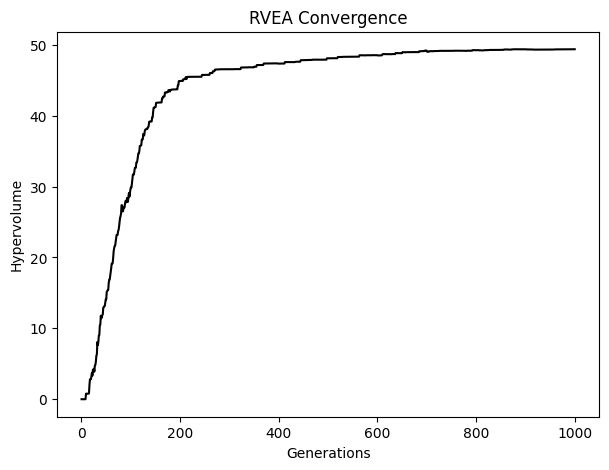

In [12]:
import matplotlib.pyplot as plt
from pymoo.indicators.hv import Hypervolume

F=res.F
n_nodes = int(res.X.shape[1]/2)
ref_point = [181, 77, 3922.81875, 1.70537209]

hist_F = []              # the objective space values in each generation

for algo in res.history:
    # retrieve the optimum from the algorithm
    opt = algo.opt

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
metric = Hypervolume(ref_point= np.array(ref_point),
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv)+1)), hv,  color='black')
plt.title("RVEA Convergence")
plt.xlabel("Generations")
plt.ylabel("Hypervolume")
plt.show()

## Pareto front plot

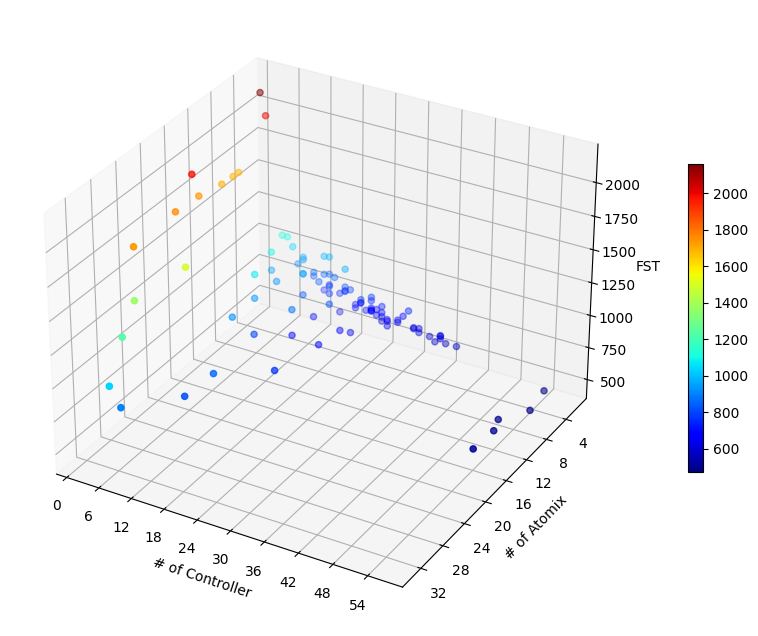

In [13]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
F=res.F

X = F[:,0]
Y = F[:,1]
Z = F[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cm = matplotlib.colormaps['jet']
ax.invert_yaxis()
p = ax.scatter(X, Y, Z, c=Z, cmap=cm)
ax.set_xlabel('# of Controller')
ax.set_ylabel('# of Atomix')
ax.set_zlabel('FST')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.colorbar(p, shrink=0.5)
plt.show()

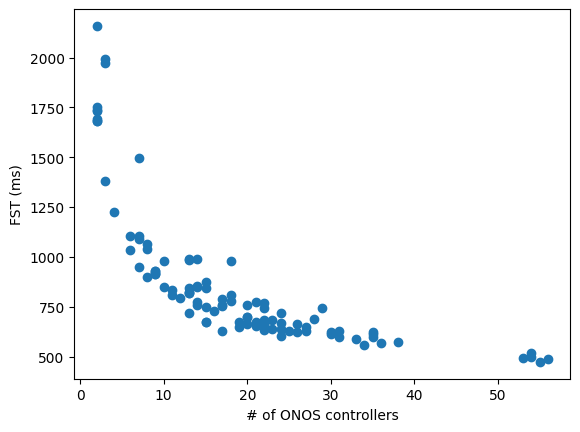

Text(0, 0.5, 'FST (ms)')

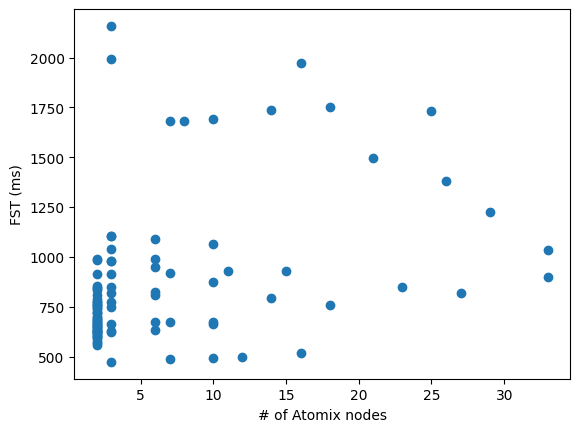

In [14]:
sorted_F_by_onos= F[np.argsort(F[:, 0])]
sorted_F_by_atomix= F[np.argsort(F[:, 1])]
sorted_F_by_fst= F[np.argsort(F[:, 2])]

X_c = sorted_F_by_onos[:,0]
Y_c = sorted_F_by_onos[:,1]
Z_c = sorted_F_by_onos[:,2]

X_a = sorted_F_by_atomix[:,0]
Y_a = sorted_F_by_atomix[:,1]
Z_a = sorted_F_by_atomix[:,2]

# ax.set_xlabel('# of Controller')
# ax.set_ylabel('# of Atomix')
# ax.set_zlabel('FST')

plt.figure()
plt.scatter(X_c,Z_c)
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.xlabel("# of ONOS controllers")
plt.ylabel("FST (ms)")
plt.show()
# and plot the objectives against each other
plt.figure()
plt.scatter(Y_a,Z_a)
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.xlabel("# of Atomix nodes")
plt.ylabel("FST (ms)")

## Visualize topology and the optimal solution
Check the optimal solution set, and pick an index you want to see.

In [15]:
# for i, o in enumerate(res.opt):
#     print(i, end=': ')
#     print(o.F)
print(F[np.argsort(F[:, 2])])

[[5.50000000e+01 3.00000000e+00 4.73475347e+02 2.08776484e-02]
 [5.60000000e+01 7.00000000e+00 4.87420832e+02 2.11533721e-02]
 [5.30000000e+01 1.00000000e+01 4.94148466e+02 2.20936446e-02]
 [5.40000000e+01 1.20000000e+01 4.98274889e+02 2.17023626e-02]
 [5.40000000e+01 1.60000000e+01 5.16156498e+02 2.17957779e-02]
 [3.40000000e+01 2.00000000e+00 5.60701061e+02 3.34434386e-02]
 [3.60000000e+01 2.00000000e+00 5.70514708e+02 3.08941161e-02]
 [3.80000000e+01 2.00000000e+00 5.72438604e+02 3.19994179e-02]
 [3.30000000e+01 2.00000000e+00 5.90857053e+02 3.37476912e-02]
 [3.50000000e+01 2.00000000e+00 5.97066816e+02 3.46352786e-02]
 [3.10000000e+01 2.00000000e+00 5.97299661e+02 3.66934919e-02]
 [2.40000000e+01 2.00000000e+00 6.03354098e+02 5.16320198e-02]
 [3.50000000e+01 2.00000000e+00 6.15973771e+02 3.31675081e-02]
 [3.00000000e+01 2.00000000e+00 6.15976626e+02 3.83293804e-02]
 [3.50000000e+01 2.00000000e+00 6.21727828e+02 3.26104381e-02]
 [3.00000000e+01 2.00000000e+00 6.23918776e+02 3.802100

Replace `opt[10]` with the index you want to visualize.

In [16]:
filtered_data = [(i, val) for i, val in enumerate(F) if val[0] == 33]
print(filtered_data)

opt = res.opt[filtered_data[0][0]]
# print(opt.F)
num_node = int(len(opt.X)/2)
red_nodes = np.nonzero(opt.X[num_node:])[0].tolist()     # Atomix nodes
green_nodes = np.nonzero(opt.X[:num_node])[0].tolist()   # Controller nodes
print(len(red_nodes))
print(len(green_nodes))
print("Atomix nodes: ", red_nodes)
print("Controller nodes: ", green_nodes)

[(83, array([3.30000000e+01, 2.00000000e+00, 5.90857053e+02, 3.37476912e-02]))]
2
33
Atomix nodes:  [146, 154]
Controller nodes:  [1, 3, 7, 12, 14, 18, 26, 28, 72, 73, 87, 94, 107, 120, 122, 123, 132, 134, 135, 143, 147, 148, 149, 152, 155, 156, 160, 162, 165, 169, 171, 183, 186]


Place the topology file downloaded from Internet Topology Zoo. Replace `read_graphml("Cogentco.graphml")` with your file.

<Axes: >

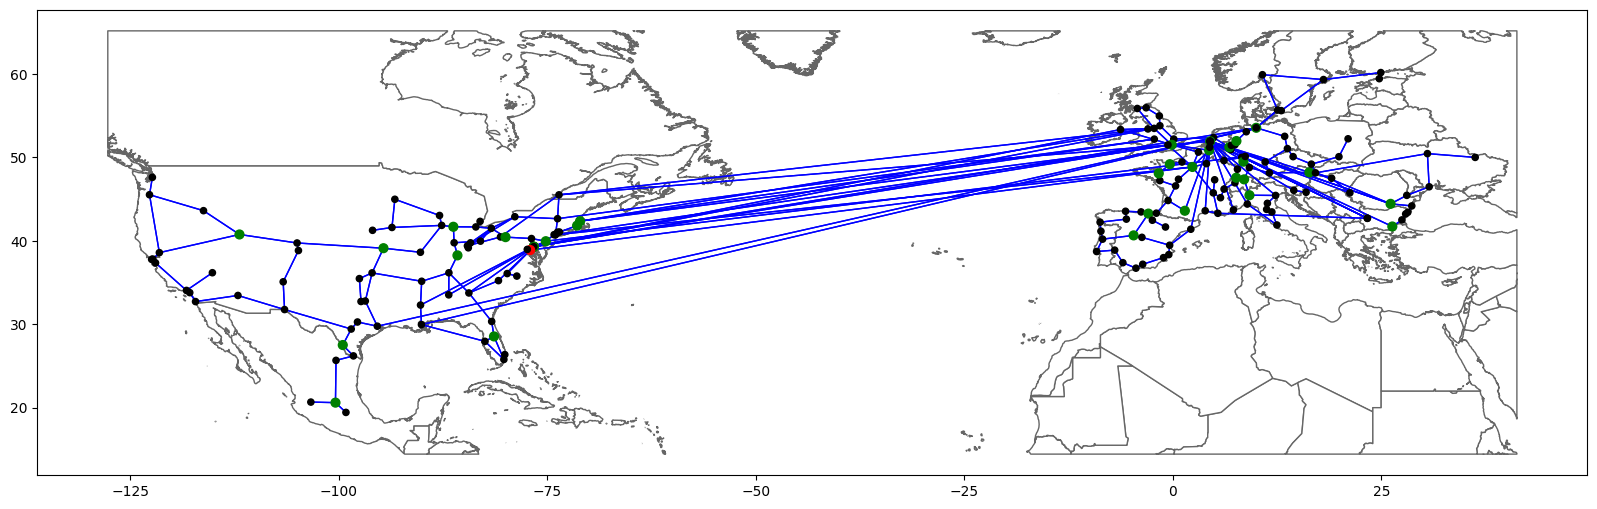

In [17]:
import geopandas as gp
from shapely.geometry import Point, LineString, MultiPoint
import matplotlib.pyplot as plt
import networkx as nx

# Load the topology file

g = nx.read_graphml("Cogentco.graphml")
# g = nx.read_graphml("UsCarrier.graphml")
nodes = {"id": [], "geometry": []}
edges = []

def refer_previous_attrs(node):
    attrs = g.nodes[str(node)]
    if "Latitude" not in attrs or "Longitude" not in attrs:
        return refer_previous_attrs(node-1)
    else:
        return attrs

for node, attrs in g.nodes(data=True):
    if "Latitude" not in attrs or "Longitude" not in attrs:
        attrs = refer_previous_attrs(int(node)-1)

    lat1, lon1 = attrs["Longitude"], attrs["Latitude"]
    nodes["id"].append(int(node))
    nodes["geometry"].append(Point(lat1, lon1))

    for src, dst in g.edges(node):
        attrs = g.nodes[dst]

        if "Latitude" not in attrs or "Longitude" not in attrs:
            attrs = refer_previous_attrs(int(dst)-1)

        lat2, lon2 = attrs["Longitude"], attrs["Latitude"]
        edges.append(LineString([(lat1, lon1), (lat2, lon2)]))

# Load and clip the map. The map files are downloaded from: https://www.naturalearthdata.com/
bounds = MultiPoint(nodes["geometry"]).bounds
world = gp.read_file("ne_10m_admin_0_countries")
world = gp.clip(world, (bounds[0]-5, bounds[1]-5, bounds[2]+5, bounds[3]+5))

base = world.plot(figsize=(20, 10), color="white", edgecolor=(0.4, 0.4, 0.4))

# Draw the edges
gdf = gp.GeoSeries(edges)
gdf.plot(ax=base, color="blue", linewidth=1)

# Draw the nodes
gdf = gp.GeoDataFrame(nodes)
# Add a new column indicating the color of each node. Nodes in red_nodes and green_nodes are colored red and green in this case.
gdf["color"] = gdf["id"].map(lambda i: "red" if i in red_nodes else ("green" if i in green_nodes else "black"))
markers = gdf["id"].map(lambda i: 40 if i in red_nodes or i in green_nodes else 20)
gdf.plot(ax=base, color=gdf["color"], markersize=markers, zorder=2)